# Part 2b - Unsupervised Learning Clusterering
## Transformer + KMeans
In this notebook, we cluster the product categories using a transformer to create embeddings and a KMeans model to cluster them.

## Imports

In [9]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import re
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# import helpers module
import helpers
import importlib
importlib.reload(helpers)

SEP = 100 * '-'


## Load dataset

In [2]:
# load dataset
data = helpers.load_pickled_dataset('pickle/data_processed.pkl')

helpers.print_random_product_sheet(data)

----------------------------------------------------------------------------------------------------
[name] All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers
----------------------------------------------------------------------------------------------------
[brand] Amazon
----------------------------------------------------------------------------------------------------
[categories] Fire Tablets,Tablets,All Tablets,Amazon Tablets,Computers & Tablets
----------------------------------------------------------------------------------------------------
[reviews.rating] 4.0
----------------------------------------------------------------------------------------------------
[reviews.numHelpful] 0.0
----------------------------------------------------------------------------------------------------
[review] Great for a teenager
Teenager friendly and easy to use. Also great for watching movies and playing games.
I recommend this product.


## Model choice



Let's reuse [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) to generate embeddings from our classes.

This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

After that, we will try a ML clustering model like KMeans, check metrics, plot the results and compare it with the Sentence Similarity method.

## Create Corpus
We can try two approches: Clustering the names of the categories, or clustering the product names concatenated by categories.

**RESULTS:**  
In this notebook too, I tried both solutions and got a better clustering with less misclassifications using categories as input, rather than product names.

In [3]:
# create corpus from categories
corpus_categories = data['categories'].unique().tolist()
print(len(corpus_categories), 'unique categories')
print(SEP)
print('Example:', corpus_categories[0])

97 unique categories
----------------------------------------------------------------------------------------------------
Example: Featured Brands,E-Readers & Accessories,EBook Readers,Tablets,Amazon Book Reader,Electronics,Computers & Tablets,Amazon Ereaders,Kindle E-readers,Amazon Devices,Tablets & E-Readers,E-Readers


In [4]:
# Create corpus from product names concatenated by categories

# Define a translation table to remove punctuation and quotes
unwanted_chars = str.maketrans('', '', string.punctuation + "'\"")

# Function to clean and de-duplicate product names
def clean_product_names(names):
    cleaned_names = set()
    for name in names:
        # Remove unwanted characters, newline, and extra whitespace
        cleaned_name = name.translate(unwanted_chars).replace("\r", "").replace("\n", "").strip()
        # Remove recurring words that carry no meaning
        black_list = ['Amazon', 'AmazonBasics']
        for word in black_list:
            if word in cleaned_name:
                cleaned_name = cleaned_name.replace(word, "").strip()
        # Remove multiple spaces
        cleaned_name = ' '.join(cleaned_name.split())
        # Add cleaned name to the set to ensure uniqueness
        cleaned_names.add(cleaned_name)
    return list(cleaned_names)

# Group by 'categories', apply cleaning, and convert to dictionary
category_product_dict = data.groupby('categories')['name'].apply(clean_product_names).to_dict()

# create corpus from product names concatenated by category
corpus_names = [','.join(products) for products in category_product_dict.values()]
print('Product names concatenated in', len(corpus_names), 'unique categories')
print(SEP)
print('Example:', corpus_names[0])

Product names concatenated in 97 unique categories
----------------------------------------------------------------------------------------------------
Example: Basics AA Performance Alkaline Batteries 48 Count Packaging May Vary


## Define corpus to use

In [5]:
# define which corpus to use in the next cells
corpus = corpus_categories  # better clustering results
# corpus = corpus_names  # poor clustering

## Load Model and create embeddings

In [6]:
# initialise model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate embeddings on both corpus
corpus_embeddings = model.encode(corpus)

print(len(corpus_embeddings), 'embeddings created')
print("Embeddings shape:", corpus_embeddings[0].shape)
print(SEP)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512_vnni.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino/openvino_model.xml:   0%|          | 0.00/211k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

97 embeddings created
Embeddings shape: (384,)
----------------------------------------------------------------------------------------------------


## Research KMeans hyperparameters
Let's try different parameters and check the elbow method and silhouette score to determine how many main categories to group them into

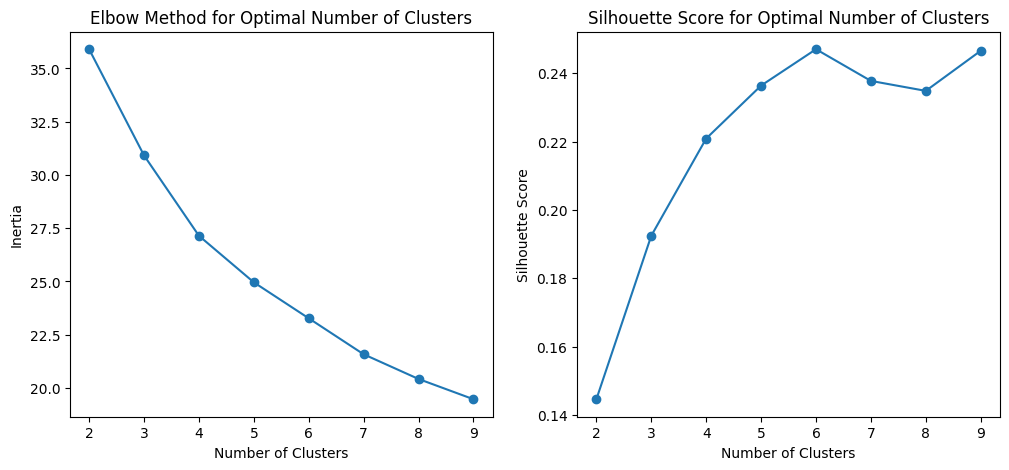

In [7]:
# Number of clusters to test
range_n_clusters = list(range(2, 10))  # Try from 2 to 10 clusters

# Store inertia and silhouette scores for each number of clusters
inertia_scores = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=20,
        max_iter=300,
        algorithm="lloyd",
        random_state=0
    )
    cluster_labels = kmeans.fit_predict(corpus_embeddings)
    
    # Store the inertia (for elbow method)
    inertia_scores.append(kmeans.inertia_)
    
    # Calculate silhouette score for each clustering result
    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the inertia and silhouette scores to determine the best number of clusters
plt.figure(figsize=(12, 5))

# Elbow Method (Inertia)
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Number of Clusters")

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Number of Clusters")

plt.show()


The inertia plot doesn’t show a very clear "elbow," but the rate of decrease starts to slow significantly after about 4 clusters. This suggests that 4 might be an efficient choice for the number of clusters, as adding more clusters beyond this point yields diminishing returns in reducing inertia.

The silhouette score increases up to 6 clusters and then remains relatively stable, peaking again at 9 clusters. A higher silhouette score suggests better-defined clusters. Based on this, we might consider using 6 clusters to balance between stability and interpretability.

## Unsupervised clustering using KMeans
Let's try 4, 5 and 6 clusters

In [8]:
# Fit KMeans clustering model
num_clusters = 6

clustering_model = KMeans(
    n_clusters=num_clusters,
    init="k-means++",
    n_init=20,
    max_iter=300,
    algorithm="lloyd",
    random_state=42
)

clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)
print()

# Organize clustered categories
corpus_clustered = [[] for _ in range(num_clusters)]
for category_id, cluster_id in enumerate(cluster_assignment):
    corpus_clustered[cluster_id].append(corpus[category_id])

# print clustering results
for i, cluster in enumerate(corpus_clustered):
    print(f"Cluster {i}: {len(cluster)} categories")


[0 0 5 3 0 2 4 2 0 0 2 2 0 2 2 0 0 4 5 2 1 1 2 1 1 0 0 0 3 2 0 1 2 3 3 2 0
 2 2 2 0 0 0 3 5 2 2 0 2 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3
 3 0 3 3 3 0 3 3 1 4 1 5 5 0 5 1 1 1 1 1 1 4 1]

Cluster 0: 29 categories
Cluster 1: 14 categories
Cluster 2: 17 categories
Cluster 3: 27 categories
Cluster 4: 4 categories
Cluster 5: 6 categories


I get the best results will less clustering errors running KMeas with 6 clusters.

In [10]:
# Save the trained model to a file
model_path = "pickle/KMeans_clustering_model.pkl"
joblib.dump(clustering_model, model_path)
print("KMeans model saved to", model_path)

KMeans model saved to pickle/KMeans_clustering_model.pkl


In [9]:
# Dictionary to store the most common words for each cluster
cluster_words = {}

# ignore some recurrent words
ignored_words = ['Amazon', 'from', 'To']

# Process each cluster
for i, cluster in enumerate(corpus_clustered):

    # Clean and prepare the cluster text
    clean_cluster = re.sub(r'[^A-Za-z0-9\s]', '', " ".join(cluster))
    all_words = [word.strip() for word in clean_cluster.split()]

    # Count frequency of each word and get top 10
    word_counts = Counter(all_words)
    for word in ignored_words:
        if word in word_counts:
            del word_counts[word]
    most_common_words = word_counts.most_common(10)

    # Store the results in the dictionary
    cluster_words[f"Cluster {i}"] = most_common_words

    # Print results for inspection
    print(f"CLUSTER {i}:")
    for word, count in most_common_words:
        print(f"{word} ({count})")
    print(SEP)

CLUSTER 0:
Book (13)
eBook (13)
Device (13)
Adapters (13)
AccessoriesKindle (11)
AccessoriesAmazon (10)
Generation (9)
Kindle (9)
ReaderComputers (8)
TabletsAmazon (7)
----------------------------------------------------------------------------------------------------
CLUSTER 1:
Home (26)
Smart (14)
Audio (14)
Device (14)
Speakers (14)
Assistant (11)
Hubs (9)
Wireless (8)
Player (7)
Hub (7)
----------------------------------------------------------------------------------------------------
CLUSTER 2:
Cases (7)
Dining (5)
Storage (5)
Accessories (5)
Computer (4)
AccessoriesLaptop (4)
Video (4)
Device (4)
File (4)
Drive (4)
----------------------------------------------------------------------------------------------------
CLUSTER 3:
Fire (19)
TabletsAmazon (12)
Tablets (12)
TabletsComputers (11)
TabletsComputersTablets (11)
eBook (11)
TabletsAll (9)
TabletsTabletsAll (8)
Readers (8)
TabletsTablets (5)
--------------------------------------------------------------------------------------

## Plot clustering results

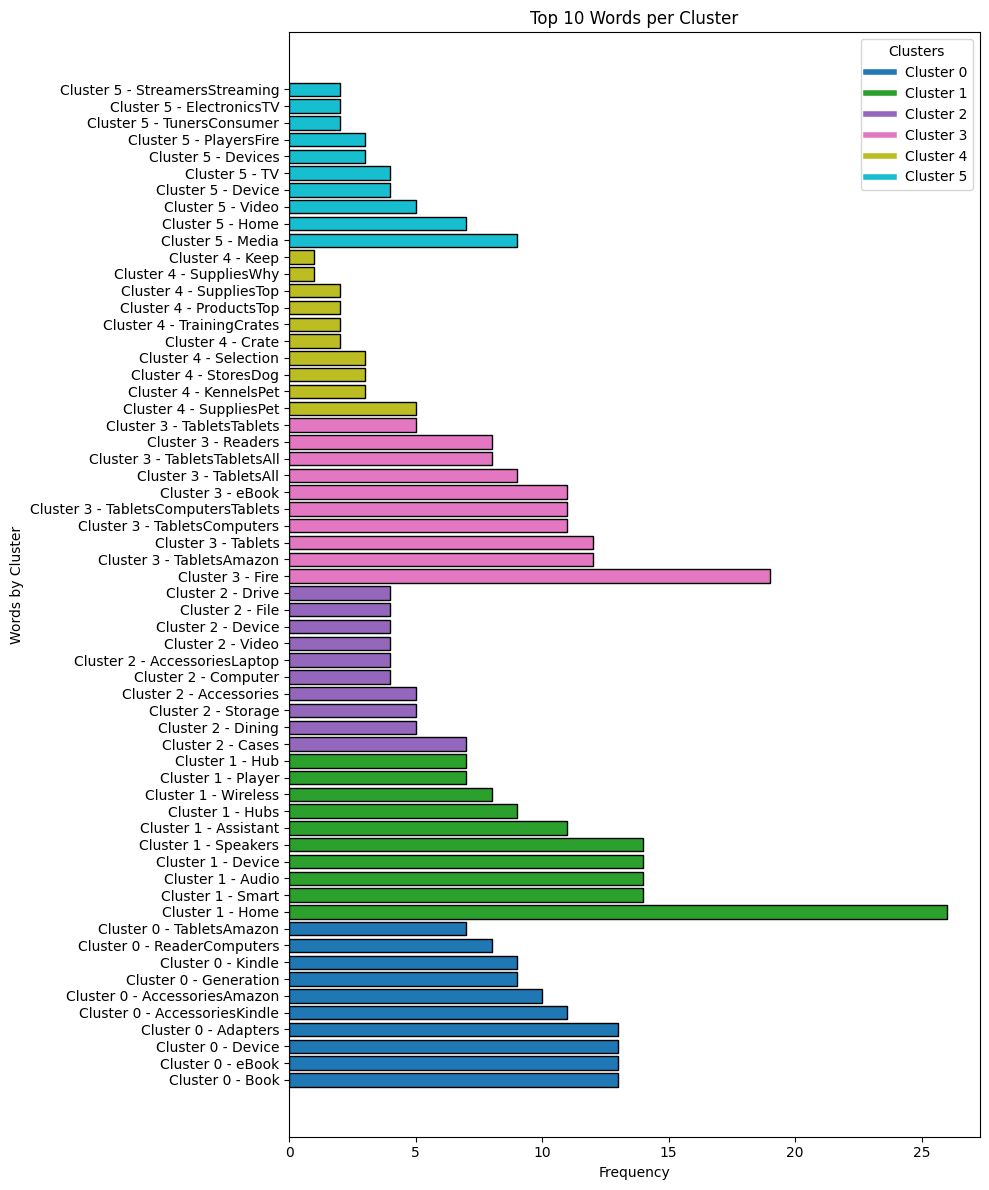

In [10]:
# Generate distinct colors for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_words)))

# Prepare data for plotting
words = []
counts = []
color_map = []
cluster_labels = []

for idx, (cluster, word_count_list) in enumerate(cluster_words.items()):
    for word, count in word_count_list:
        words.append(f"{cluster} - {word}")
        counts.append(count)
        color_map.append(colors[idx])
        cluster_labels.append(cluster)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(words, counts, color=color_map, edgecolor="black")

# Legend
legend_labels = [f"Cluster {i}" for i in range(len(cluster_words))]
unique_colors = [colors[i] for i in range(len(cluster_words))]
custom_legend = [plt.Line2D([0], [0], color=unique_colors[i], lw=4) for i in range(len(unique_colors))]
plt.legend(custom_legend, legend_labels, title="Clusters", loc="upper right")

# Labels and title
plt.ylabel("Words by Cluster")
plt.xlabel("Frequency")
plt.title("Top 10 Words per Cluster")

plt.tight_layout()
plt.show()

In [11]:
# Calculate silhouette score
silhouette_avg = silhouette_score(corpus_embeddings, clustering_model.labels_)
print(f'Silhouette Score: {silhouette_avg:.4f}')


Silhouette Score: 0.2442


A silhouette score of 0.2389 indicates that the clusters are somewhat loosely defined, meaning there may be overlapping clusters or that some data points are not well-separated from others.

In [12]:
db_index = davies_bouldin_score(corpus_embeddings, clustering_model.labels_)
ch_score = calinski_harabasz_score(corpus_embeddings, clustering_model.labels_)

print(f'Davies-Bouldin Index: {db_index}')
print(f'Calinski-Harabasz Index: {ch_score}')


Davies-Bouldin Index: 1.6729268101033294
Calinski-Harabasz Index: 15.39247193770258


The Davies-Bouldin Index indicates there is some separation but not strong compactness within clusters.

The Calinski-Harabasz Index being low supports this, pointing to possible overlap between clusters or diffuse clustering boundaries.

## Visualise clustering results
Let's use t-SNE to visualise our clusters once we reduce the results to 2 dimensions

/tmp/ipykernel_473/1293722192.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)
/tmp/ipykernel_473/1293722192.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


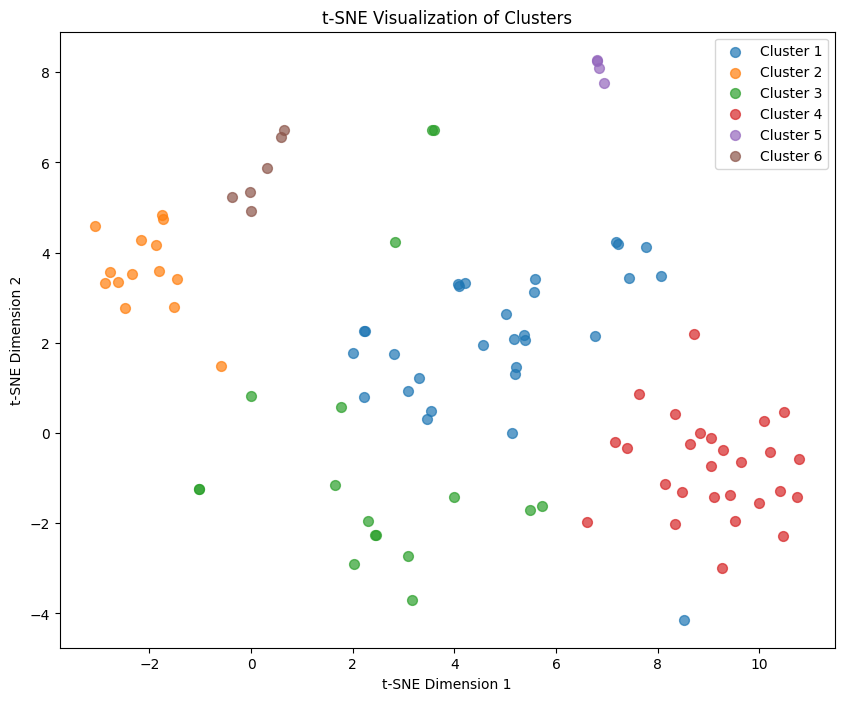

In [13]:
# Step 1: Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(corpus_embeddings)

# Step 2: Get cluster labels from your clustering model
cluster_labels = clustering_model.labels_

# Define colors for each cluster
num_clusters = len(set(cluster_labels))
colors = plt.cm.get_cmap("tab10", num_clusters)

# Step 3: Plot each cluster with a different color
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    indices = np.where(cluster_labels == cluster)
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        label=f"Cluster {cluster + 1}",
        cmap=colors,
        alpha=0.7,
        s=50
    )

plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


The t-SNE visualization shows fairly well-separated clusters, which is a positive sign that the KMeans clustering worked effectively.

Most clusters are well-separated, with distinct groupings for clusters 1, 2, and 6 in particular. This indicates that embeddings and clustering configuration captured meaningful differences between these categories.

Clusters 1, 2, and 6 appear more compact, suggesting strong cohesion within those groups.

Clusters 3 and 4 are a bit more spread out, which might reflect more internal variability within those categories.

There is minimal overlap between clusters, which is a positive sign for a clean segmentation of categories.

Cluster 4 is slightly closer to clusters 1 and 3, but they’re still visually distinguishable, so this isn’t necessarily an issue.

## Let's rename our clusters and add them to the dataset

In [14]:
# manually assigning names to each cluster
cluster_names = {
    0: "Electronics & Media",
    1: "Tablets & eReaders",
    2: "Accessories & Adapters",
    3: "Home & Smart Devices",
    4: "Pet Supplies",
    5: "Video & Streaming"
}

# clustering the corpus: each category receives a cluster name
clustered_corpus = {}
for i, cat in enumerate(corpus):
    clustered_corpus[cat] = cluster_names[cluster_assignment[i]]

# update dataset with a new column
data_clustered = data.copy()
data_clustered['clusterCategories'] = data_clustered['categories'].map(clustered_corpus)

# drop othe categories column
data_clustered.drop('categories', axis=1, inplace=True)

print(data_clustered.info())
data_clustered.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59046 entries, 0 to 59045
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                59046 non-null  object 
 1   brand               59046 non-null  object 
 2   reviews.rating      59046 non-null  float64
 3   reviews.numHelpful  59046 non-null  float64
 4   review              59046 non-null  object 
 5   clusterCategories   59046 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.7+ MB
None


,name,brand,reviews.rating,reviews.numHelpful,review,clusterCategories
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,8.0,Great device for reading. Definately pricey.\n...,Electronics & Media
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,3.0,"Excellent Kindle\nThe best Kindle ever, for me...",Electronics & Media
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,1.0,Love it\nI absolutely love this reader. The bi...,Electronics & Media
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,0.0,Good kindle\nI always use it when i read ebook...,Electronics & Media
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,9.0,"So much to love, but slippery\nLove bigger scr...",Electronics & Media
5,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,4.0,Expensive but nice\nI was used to the Kindle 3...,Electronics & Media
6,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,3.0,Like it\nI love this so far only downside is y...,Electronics & Media
7,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,2.0,Love it!\nI adore this kindle. I have owned vo...,Electronics & Media
8,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,1.0,"You get what you pay for\nBest reader, super l...",Electronics & Media
9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,0.0,Best Kindle ever....\nThis is the best Kindle ...,Electronics & Media


In [33]:
helpers.print_random_product_sheet(data_clustered)

----------------------------------------------------------------------------------------------------
[name] Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta
----------------------------------------------------------------------------------------------------
[brand] Amazon
----------------------------------------------------------------------------------------------------
[reviews.rating] 5.0
----------------------------------------------------------------------------------------------------
[reviews.numHelpful] 0.0
----------------------------------------------------------------------------------------------------
[review] Nice table
Very very good table nice definition and quality I like
I recommend this product.
----------------------------------------------------------------------------------------------------
[clusterCategories] Home & Smart Devices


## Pickle categorized dataset

In [16]:
data_clustered.to_pickle('pickle/data_clustered.pkl')